# Transfer Learning: Computer Vision in PyTorch


There are two major transfer learning options:

1. __Finetuning the convnet__: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on ImageNet 1000 dataset. Rest of the training looks as usual.

1. __ConvNet as fixed feature extractor__: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


- [CS231n Transfer Learning](https://cs231n.github.io/transfer-learning/)

- [PyTorch reference](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

from tqdm import tqdm
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import time, os, copy, pickle

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 2
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


### Load _hymenoptera_ dataset

We will use ```torchvision``` and ```torch.utils.data``` packages for loading the dataset.

The problem statement is to train a CNN architecture/model to classify the two classes in the dataset, viz., ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [5]:
# Define data augmentation and normalization for training and just normalization for validation-
data_transforms = {
    'train': transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    ),
    'val': transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    ),
}

In [6]:
# Define dataset directory-
data_dir = 'hymenoptera_data'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

In [7]:
# Define dataloader-
dataloader = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size = 32,
        shuffle = True, num_workers = 4)
    for x in ['train', 'val']
}

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [9]:
print(f"number of training steps in one epoch = {len(dataloader['train'])} using batchs-size = 32")
print(f"number of training steps in one epoch = {len(dataloader['val'])} using batchs-size = 32")

number of training steps in one epoch = 8 using batchs-size = 32
number of training steps in one epoch = 5 using batchs-size = 32


In [10]:
# Sanity check-
len(image_datasets['train']) / 32, len(image_datasets['val']) / 32

(7.625, 4.78125)

In [11]:
def imshow(inp, title = None):
    """
    Function to visualize images. imshow() for tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Unnormalize tensor-
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize = (12, 11))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # pause a bit so that plots are updated-
    plt.pause(0.001)
    plt.show()
    
    return None


In [12]:
# Retrieve a batch of training data-
imgs, targets = next(iter(dataloader['train']))
imgs.shape, targets.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

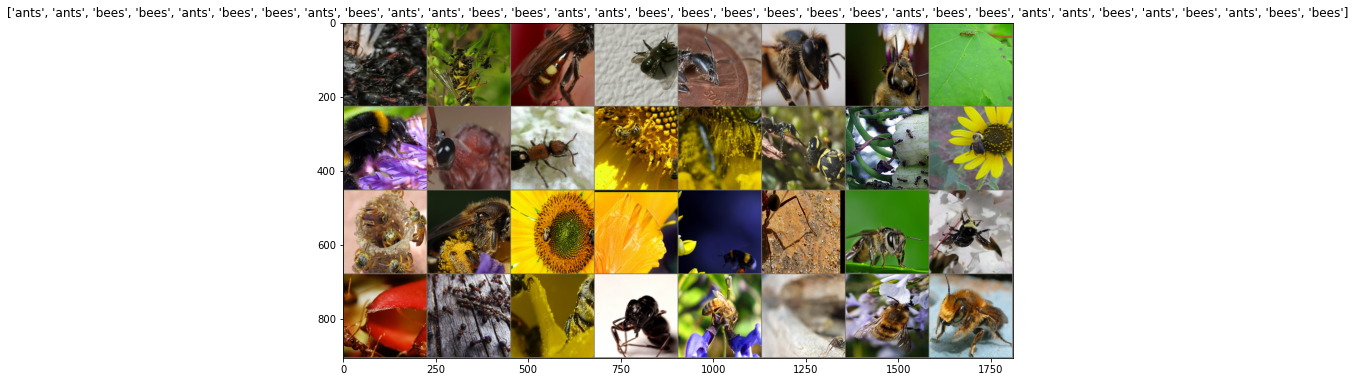

In [13]:
# Make a grid from batch-
out = torchvision.utils.make_grid(imgs)

# Visualize sample images-
imshow(out, title = [class_names[x] for x in targets])

### Fine-Tune pre-trained _ResNet-18_ CNN architecture

In [14]:
def resnet18_pretrained():
    '''
    Function to load pre-trained ResNet-18 for binary classification.
    '''
    # Load a pre-trained ResNet18 CNN model-
    model_resnet18 = models.resnet18(pretrained = True)
    
    num_ftrs = model_resnet18.fc.in_features
    
    # Change output layer to have two outputs-
    model_resnet18.fc = nn.Linear(
        in_features = num_ftrs, out_features = len(class_names)
    )
    
    return model_resnet18


In [15]:
# Initialize a pre-trained ResNet-18 CNN architecture-
model_resnet18 = resnet18_pretrained()

In [ ]:
'''
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model_resnet18.parameters():
    print(f"layer.shape = {param.detach().numpy().shape} has {param.nelement()} parameters")
    tot_params += param.nelement()
'''

In [16]:
tot_params = 0

# Print layer names-
for layer in model_resnet18.state_dict().keys():
    print(f"{layer} has dimension = {model_resnet18.state_dict()[layer].detach().numpy().shape}")
    tot_params += model_resnet18.state_dict()[layer].numpy().size

conv1.weight has dimension = (64, 3, 7, 7)
bn1.weight has dimension = (64,)
bn1.bias has dimension = (64,)
bn1.running_mean has dimension = (64,)
bn1.running_var has dimension = (64,)
bn1.num_batches_tracked has dimension = ()
layer1.0.conv1.weight has dimension = (64, 64, 3, 3)
layer1.0.bn1.weight has dimension = (64,)
layer1.0.bn1.bias has dimension = (64,)
layer1.0.bn1.running_mean has dimension = (64,)
layer1.0.bn1.running_var has dimension = (64,)
layer1.0.bn1.num_batches_tracked has dimension = ()
layer1.0.conv2.weight has dimension = (64, 64, 3, 3)
layer1.0.bn2.weight has dimension = (64,)
layer1.0.bn2.bias has dimension = (64,)
layer1.0.bn2.running_mean has dimension = (64,)
layer1.0.bn2.running_var has dimension = (64,)
layer1.0.bn2.num_batches_tracked has dimension = ()
layer1.1.conv1.weight has dimension = (64, 64, 3, 3)
layer1.1.bn1.weight has dimension = (64,)
layer1.1.bn1.bias has dimension = (64,)
layer1.1.bn1.running_mean has dimension = (64,)
layer1.1.bn1.running_var h

In [17]:
print(f"Total number of parameters in ResNet-18 CNN = {tot_params}")

Total number of parameters in ResNet-18 CNN = 11187158


In [18]:
# Sanity check- output layer has 2 neurons?
model_resnet18.fc

Linear(in_features=512, out_features=2, bias=True)

### Multi-GPU Training in PyTorch

- [Multi-GPU Examples](https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html)

- [Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

In [ ]:
# Use all available GPUs-
model_resnet18 = nn.DataParallel(model_resnet18)
model_resnet18.to(device)

#### Step-wise LR decay scheduler

Number of training steps/iterations per epoch = 8 using a batch-size = 32. Therefore, number of training steps in 7 epochs = 7 x 8 = 56 and not 7 (as mentioned in PyTorch's tutorial)!!

In [ ]:
# Define loss function-
loss = nn.CrossEntropyLoss()

# Define SGD optimizer-
optimizer = optim.SGD(model_resnet18.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs-
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 8 * 7, gamma = 0.1)

In [ ]:
# Sanity check-
optimizer.param_groups[0]['lr']

In [22]:
# Sanity check-
x, y = next(iter(dataloader['train']))
x = x.to(device)
y = y.to(device)

x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [23]:
out = model_resnet18(x)
out.shape

torch.Size([32, 2])

In [24]:
del x, y, out

In [25]:
def train_model_progress(model, train_loader, lr_scheduler):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # LR decay scheduler-
            lr_scheduler.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(image_datasets['train']),
                accuracy = (running_corrects.double().cpu().numpy() / len(image_datasets['train'])) * 100
            )
            
    
    # train_loss = running_loss / len(train_dataset)
    train_loss = running_loss / len(image_datasets['train'])
    # train_acc = (running_corrects.double() / len(train_dataset)) * 100
    train_acc = (running_corrects.double() / len(image_datasets['train'])) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [26]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(image_datasets['train']),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(image_datasets['train'])
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [28]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

In [29]:
# Initialize parameters saving 'best' models-
best_val_acc = 0

In [30]:
for epoch in range(20):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model_resnet18, train_loader = dataloader['train'],
        lr_scheduler = step_lr_scheduler
    )
    val_loss, val_acc = test_model_progress(model = model_resnet18, test_loader = dataloader['val'])
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model_resnet18.state_dict(), "ResNet18_hymenoptera_best_model.pth")
        

Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45batch/s, val_acc=75.2, val_loss=0.336]



epoch: 1 training loss = 0.6817, training accuracy = 56.56%, val_loss = 0.3359, val_accuracy = 75.16% & LR = 0.0010

Saving model with highest val_acc = 75.1634



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.69batch/s, val_acc=89.5, val_loss=0.219]



epoch: 2 training loss = 0.5144, training accuracy = 71.72%, val_loss = 0.2189, val_accuracy = 89.54% & LR = 0.0010

Saving model with highest val_acc = 89.5425



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67batch/s, val_acc=91.5, val_loss=0.16]



epoch: 3 training loss = 0.3223, training accuracy = 88.52%, val_loss = 0.1596, val_accuracy = 91.50% & LR = 0.0010

Saving model with highest val_acc = 91.5033



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95batch/s, val_acc=92.2, val_loss=0.135]



epoch: 4 training loss = 0.2715, training accuracy = 88.52%, val_loss = 0.1350, val_accuracy = 92.16% & LR = 0.0010

Saving model with highest val_acc = 92.1569



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.03batch/s, val_acc=93.5, val_loss=0.12]



epoch: 5 training loss = 0.2079, training accuracy = 92.62%, val_loss = 0.1198, val_accuracy = 93.46% & LR = 0.0010

Saving model with highest val_acc = 93.4641



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05batch/s, val_acc=92.8, val_loss=0.114]



epoch: 6 training loss = 0.1814, training accuracy = 93.85%, val_loss = 0.1138, val_accuracy = 92.81% & LR = 0.0010



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94batch/s, val_acc=93.5, val_loss=0.11]



epoch: 7 training loss = 0.1553, training accuracy = 93.44%, val_loss = 0.1103, val_accuracy = 93.46% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60batch/s, val_acc=92.8, val_loss=0.114]



epoch: 8 training loss = 0.2305, training accuracy = 90.98%, val_loss = 0.1136, val_accuracy = 92.81% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90batch/s, val_acc=93.5, val_loss=0.111]



epoch: 9 training loss = 0.1466, training accuracy = 95.08%, val_loss = 0.1114, val_accuracy = 93.46% & LR = 0.0001



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98batch/s, val_acc=93.5, val_loss=0.11]



epoch: 10 training loss = 0.1887, training accuracy = 93.44%, val_loss = 0.1104, val_accuracy = 93.46% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.48batch/s, val_acc=92.8, val_loss=0.112]



epoch: 11 training loss = 0.1874, training accuracy = 92.21%, val_loss = 0.1116, val_accuracy = 92.81% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.03batch/s, val_acc=93.5, val_loss=0.111]



epoch: 12 training loss = 0.1790, training accuracy = 93.85%, val_loss = 0.1109, val_accuracy = 93.46% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82batch/s, val_acc=93.5, val_loss=0.112]



epoch: 13 training loss = 0.1807, training accuracy = 93.85%, val_loss = 0.1125, val_accuracy = 93.46% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.05batch/s, val_acc=94.1, val_loss=0.113]



epoch: 14 training loss = 0.1557, training accuracy = 94.67%, val_loss = 0.1130, val_accuracy = 94.12% & LR = 0.0000

Saving model with highest val_acc = 94.1176



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53batch/s, val_acc=93.5, val_loss=0.11]



epoch: 15 training loss = 0.1964, training accuracy = 91.80%, val_loss = 0.1104, val_accuracy = 93.46% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11batch/s, val_acc=93.5, val_loss=0.111]



epoch: 16 training loss = 0.1724, training accuracy = 94.26%, val_loss = 0.1107, val_accuracy = 93.46% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.19batch/s, val_acc=93.5, val_loss=0.111]



epoch: 17 training loss = 0.1817, training accuracy = 93.85%, val_loss = 0.1106, val_accuracy = 93.46% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.97batch/s, val_acc=92.8, val_loss=0.111]



epoch: 18 training loss = 0.1543, training accuracy = 95.08%, val_loss = 0.1109, val_accuracy = 92.81% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.03batch/s, val_acc=93.5, val_loss=0.111]



epoch: 19 training loss = 0.1973, training accuracy = 91.39%, val_loss = 0.1114, val_accuracy = 93.46% & LR = 0.0000



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06batch/s, val_acc=93.5, val_loss=0.11]



epoch: 20 training loss = 0.1430, training accuracy = 95.90%, val_loss = 0.1104, val_accuracy = 93.46% & LR = 0.0000



In [32]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_hymenoptera_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [36]:
# Initialize and load 'best' trained parameters from above-
best_model = resnet18_pretrained()

# Utilize all available GPUs-
best_model = nn.DataParallel(best_model)
best_model.to(device)
best_model.load_state_dict(torch.load("ResNet18_hymenoptera_best_model.pth"))

<All keys matched successfully>

In [37]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(model = best_model, test_loader = dataloader['val'])

Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66batch/s, val_acc=94.1, val_loss=0.113]


In [38]:
print(f"ResNet-18 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

ResNet-18 'best' model metrics: val_loss = 0.1130 & val_acc = 94.12%


In [39]:
del model_resnet18, best_model

### ResNet-18 Transfer Learning Visualization

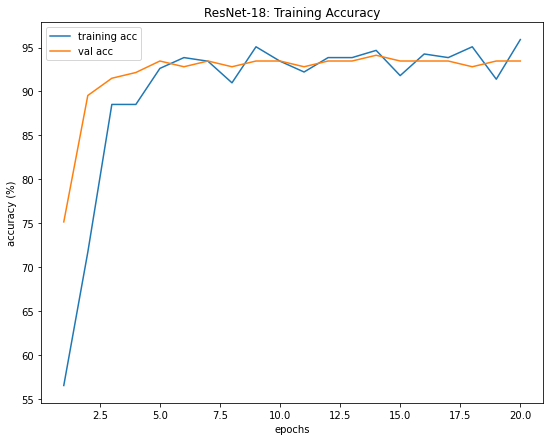

In [33]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

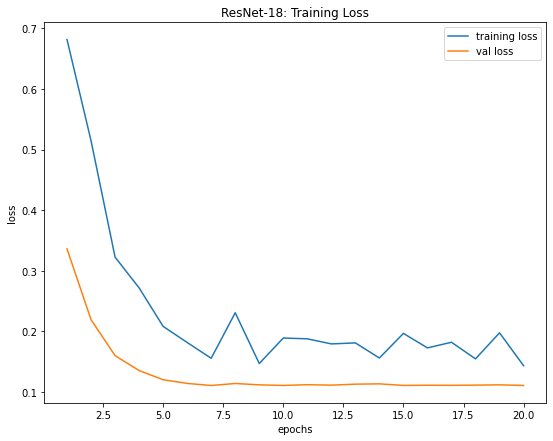

In [34]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: Training Loss")
plt.show()

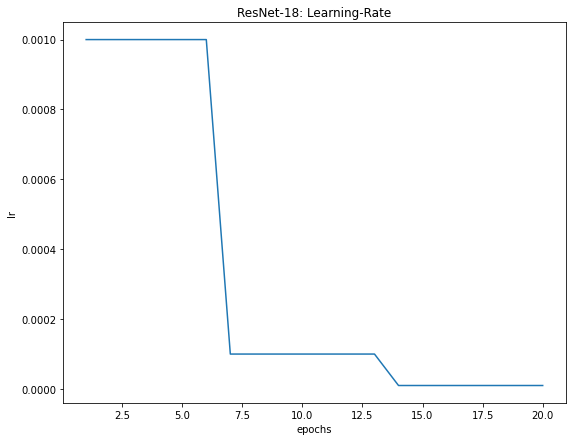

In [35]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: Learning-Rate")
plt.show()

### CNN as fixed feature extractor

Here, we need to freeze all of the CNN except for the output layer. We need to set ```requires_grad = False``` to freeze the parameters so that the gradients are not computed in ```backward()```.

You can read more about this in the documentation [here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).

In [40]:
def resnet18_pretrained_feature_extractor():
    '''
    Function to load pre-trained ResNet-18 for binary classification.
    Using feature extractor method.
    '''
    # Load a pre-trained ResNet18 CNN model-
    model_resnet18_fe = models.resnet18(pretrained = True)
    
    # Iterate through all trainable layers and freeze parameters-
    for param in model_resnet18_fe.parameters():
        param.requires_grad = False
    
    # Parameters of newly constructed modules have requires_grad=True by default-
    num_ftrs = model_resnet18_fe.fc.in_features
    
    # Change output layer to have two outputs-
    model_resnet18_fe.fc = nn.Linear(
        in_features = num_ftrs, out_features = len(class_names)
    )
    
    return model_resnet18_fe


In [48]:
# Initialize a pre-trained ResNet-18 CNN architecture-
model_resnet18_fe = resnet18_pretrained_feature_extractor()

In [ ]:
# Use all available GPUs-
model_resnet18_fe = nn.DataParallel(model_resnet18_fe)
model_resnet18_fe.to(device)

In [50]:
# Define loss function-
loss = nn.CrossEntropyLoss()

# Define SGD optimizer-
optimizer = optim.SGD(model_resnet18_fe.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs-
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 8 * 7, gamma = 0.1)

In [51]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.001

In [52]:
# Sanity check-
x, y = next(iter(dataloader['train']))
x = x.to(device)
y = y.to(device)

x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [53]:
out = model_resnet18_fe(x)
out.shape

torch.Size([32, 2])

In [54]:
del x, y, out

In [55]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler_fe = {}

In [56]:
# Initialize parameters saving 'best' models-
best_val_acc = 0

In [57]:
for epoch in range(20):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model_resnet18_fe, train_loader = dataloader['train'],
        lr_scheduler = step_lr_scheduler
    )
    val_loss, val_acc = test_model_progress(model = model_resnet18_fe, test_loader = dataloader['val'])
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model_resnet18_fe.state_dict(), "ResNet18_hymenoptera_best_model_feature_extractor.pth")
        

Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.08batch/s, val_acc=75.8, val_loss=0.321]



epoch: 1 training loss = 0.6590, training accuracy = 59.43%, val_loss = 0.3210, val_accuracy = 75.82% & LR = 0.0010

Saving model with highest val_acc = 75.8170



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76batch/s, val_acc=88.9, val_loss=0.236]



epoch: 2 training loss = 0.5667, training accuracy = 71.72%, val_loss = 0.2356, val_accuracy = 88.89% & LR = 0.0010

Saving model with highest val_acc = 88.8889



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75batch/s, val_acc=90.8, val_loss=0.193]



epoch: 3 training loss = 0.4513, training accuracy = 80.74%, val_loss = 0.1932, val_accuracy = 90.85% & LR = 0.0010

Saving model with highest val_acc = 90.8497



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67batch/s, val_acc=92.8, val_loss=0.161]



epoch: 4 training loss = 0.3398, training accuracy = 88.11%, val_loss = 0.1612, val_accuracy = 92.81% & LR = 0.0010

Saving model with highest val_acc = 92.8105



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.10batch/s, val_acc=94.1, val_loss=0.144]



epoch: 5 training loss = 0.3339, training accuracy = 90.98%, val_loss = 0.1443, val_accuracy = 94.12% & LR = 0.0010

Saving model with highest val_acc = 94.1176



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.91batch/s, val_acc=94.8, val_loss=0.132]



epoch: 6 training loss = 0.2608, training accuracy = 92.62%, val_loss = 0.1316, val_accuracy = 94.77% & LR = 0.0010

Saving model with highest val_acc = 94.7712



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25batch/s, val_acc=94.1, val_loss=0.126]



epoch: 7 training loss = 0.2637, training accuracy = 91.39%, val_loss = 0.1258, val_accuracy = 94.12% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04batch/s, val_acc=95.4, val_loss=0.127]



epoch: 8 training loss = 0.2334, training accuracy = 93.44%, val_loss = 0.1273, val_accuracy = 95.42% & LR = 0.0001

Saving model with highest val_acc = 95.4248



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72batch/s, val_acc=94.1, val_loss=0.126]



epoch: 9 training loss = 0.2661, training accuracy = 87.30%, val_loss = 0.1263, val_accuracy = 94.12% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44batch/s, val_acc=94.8, val_loss=0.127]



epoch: 10 training loss = 0.2718, training accuracy = 90.57%, val_loss = 0.1269, val_accuracy = 94.77% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.67batch/s, val_acc=95.4, val_loss=0.125]



epoch: 11 training loss = 0.2537, training accuracy = 91.80%, val_loss = 0.1253, val_accuracy = 95.42% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12batch/s, val_acc=95.4, val_loss=0.127]



epoch: 12 training loss = 0.2218, training accuracy = 93.44%, val_loss = 0.1273, val_accuracy = 95.42% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.50batch/s, val_acc=95.4, val_loss=0.128]



epoch: 13 training loss = 0.2440, training accuracy = 91.80%, val_loss = 0.1279, val_accuracy = 95.42% & LR = 0.0001



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36batch/s, val_acc=94.8, val_loss=0.127]



epoch: 14 training loss = 0.2643, training accuracy = 88.93%, val_loss = 0.1270, val_accuracy = 94.77% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48batch/s, val_acc=94.1, val_loss=0.124]



epoch: 15 training loss = 0.2344, training accuracy = 95.90%, val_loss = 0.1245, val_accuracy = 94.12% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97batch/s, val_acc=94.1, val_loss=0.124]



epoch: 16 training loss = 0.2644, training accuracy = 91.39%, val_loss = 0.1240, val_accuracy = 94.12% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.61batch/s, val_acc=94.1, val_loss=0.125]



epoch: 17 training loss = 0.2718, training accuracy = 90.98%, val_loss = 0.1248, val_accuracy = 94.12% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88batch/s, val_acc=94.8, val_loss=0.123]



epoch: 18 training loss = 0.2657, training accuracy = 91.80%, val_loss = 0.1233, val_accuracy = 94.77% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55batch/s, val_acc=94.1, val_loss=0.126]



epoch: 19 training loss = 0.2665, training accuracy = 90.98%, val_loss = 0.1260, val_accuracy = 94.12% & LR = 0.0000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.19batch/s, val_acc=94.8, val_loss=0.124]


epoch: 20 training loss = 0.2719, training accuracy = 90.57%, val_loss = 0.1239, val_accuracy = 94.77% & LR = 0.0000



In [58]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_hymenoptera_training_history_lr_scheduler_feature_extractor.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler_fe, file)

In [59]:
# Initialize and load 'best' trained parameters from above-
best_model = resnet18_pretrained_feature_extractor()

# Utilize all available GPUs-
best_model = nn.DataParallel(best_model)
best_model.to(device)
best_model.load_state_dict(torch.load("ResNet18_hymenoptera_best_model_feature_extractor.pth"))

<All keys matched successfully>

In [60]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(model = best_model, test_loader = dataloader['val'])

Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.20batch/s, val_acc=95.4, val_loss=0.127]


In [64]:
print(f"ResNet-18 'best' model metrics (feature extractor): val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

ResNet-18 'best' model metrics (feature extractor): val_loss = 0.1273 & val_acc = 95.42%


In [63]:
del model_resnet18_fe, best_model

### ResNet-18 (Feature Extractor) Transfer Learning Visualization

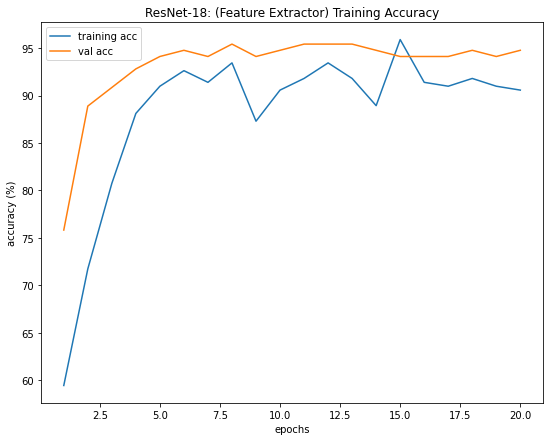

In [65]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: (Feature Extractor) Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

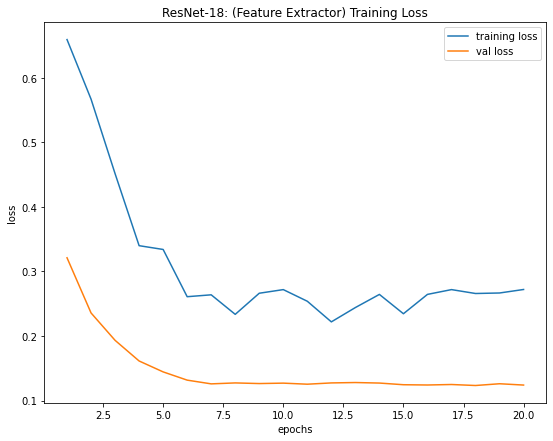

In [66]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: (Feature Extractor) Training Loss")
plt.show()

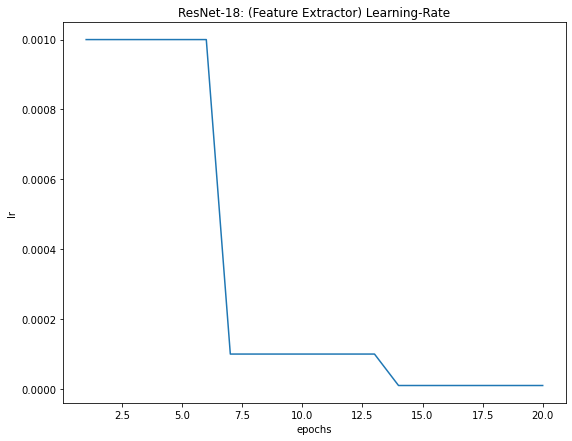

In [67]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: (Feature Extractor) Learning-Rate")
plt.show()